### Amy Cho - 604 Final Project Group 18

In [42]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import sklearn.metrics as skmetrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

import warnings                               
warnings.filterwarnings('ignore')

In [43]:
df = pd.read_csv('train.csv')
df.head()

,Datetime,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2018-01-01 06:20:00+00:00,26.212347,28.696304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.00,3.976499,NaN,NaN,252.00,3.042750
1,2018-01-01 06:40:00+00:00,59.632658,29.052567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.00,11.091660,NaN,NaN,255.00,3.424814
2,2018-01-01 06:50:00+00:00,40.889650,28.984758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.75,4.234497,NaN,NaN,264.75,3.507172
3,2018-01-01 10:40:00+00:00,34.398111,30.282058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.75,5.347792,NaN,NaN,283.75,3.442212
4,2018-01-01 12:00:00+00:00,29.797653,29.333519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.00,6.022326,NaN,NaN,274.00,3.031363


In [44]:
df.isnull().sum(), len(df)

(Datetime                            0
 ActivePower                         0
 AmbientTemperatue                 896
 BearingShaftTemperature         26684
 Blade1PitchAngle                43282
 Blade2PitchAngle                43365
 Blade3PitchAngle                43365
 GearboxBearingTemperature       26682
 GearboxOilTemperature           26670
 GeneratorRPM                    26674
 GeneratorWinding1Temperature    26656
 GeneratorWinding2Temperature    26649
 HubTemperature                  26792
 MainBoxTemperature              26704
 NacellePosition                 20424
 ReactivePower                      42
 RotorRPM                        26680
 TurbineStatus                   26466
 WindDirection                   20424
 WindSpeed                         308
 dtype: int64,
 77202)

In [45]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)
df_interpolated = df.interpolate()

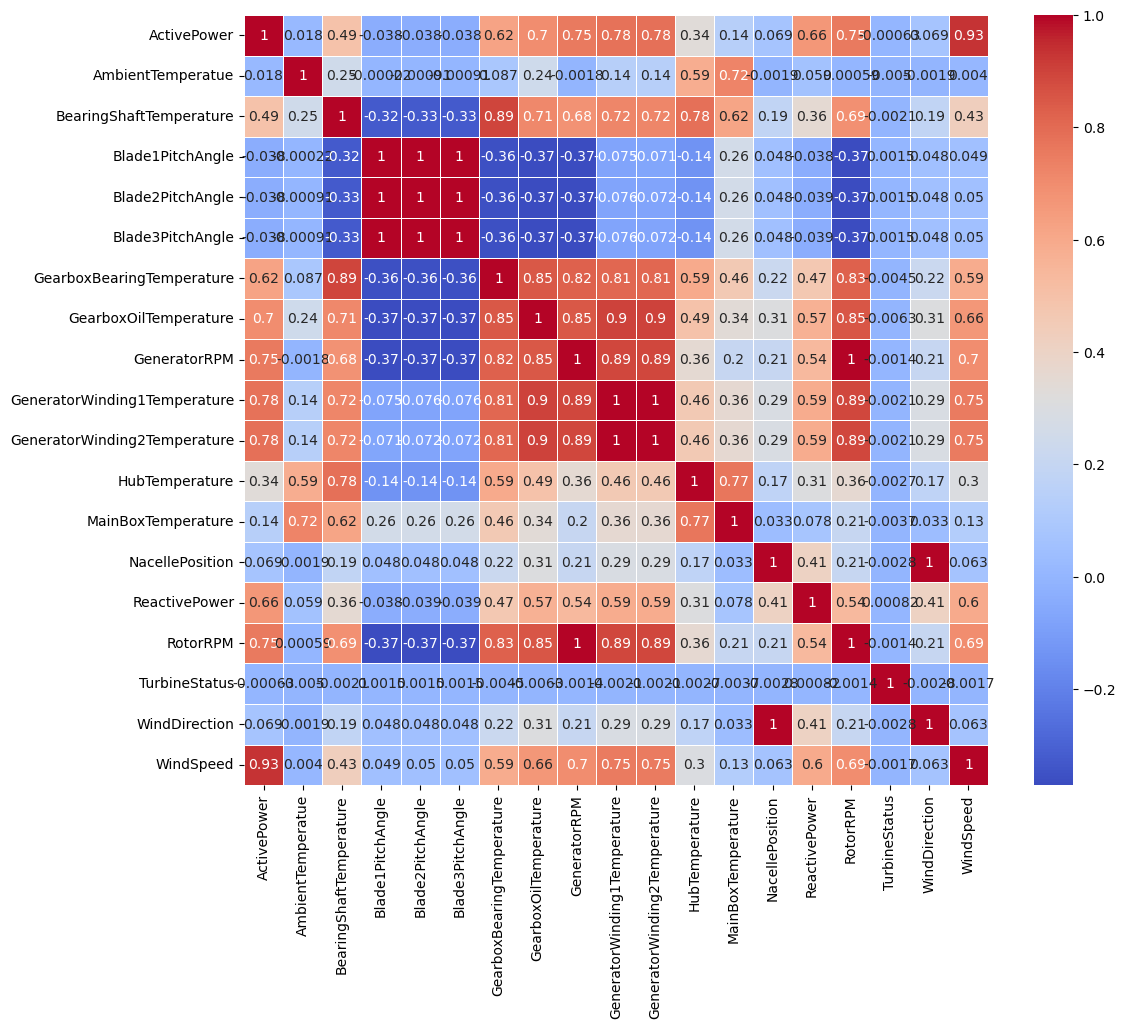

In [46]:
plt.figure(figsize=(12, 10))
sns.heatmap(df_interpolated.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.show()


In [47]:
daily_df = df[['ActivePower', 'WindSpeed']].resample('D').mean()
daily_df = daily_df.interpolate()
daily_df.head()

,ActivePower,WindSpeed
Datetime,,
2018-01-01 00:00:00+00:00,366.223561,5.263797
2018-01-02 00:00:00+00:00,462.550740,5.390719
2018-01-03 00:00:00+00:00,454.417752,5.295225
2018-01-04 00:00:00+00:00,369.952190,5.094994
2018-01-05 00:00:00+00:00,319.446595,4.915224


<Axes: xlabel='Datetime'>

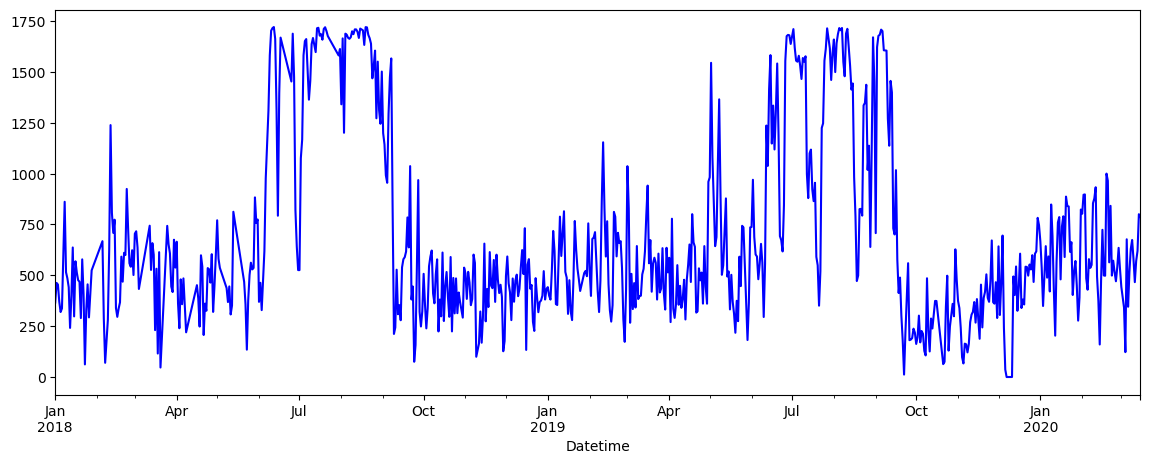

In [48]:
f, ax = plt.subplots(figsize=(14,5))
daily_df['ActivePower'].plot(kind='line',y='0',color='blue', label='history', ax=ax)

In [49]:
#check trend with MA smoothing
#def a moving average plot
def plotMovingAverage(series, window, plot_actual=False, scale=1.96):

    rolling_mean = series.rolling(window=window,center=True).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    if plot_actual:
        plt.plot(series[window:], label="Actual values", color='#878a88', alpha=0.5)
        
    plt.legend(loc="upper left") 
    plt.grid(True)

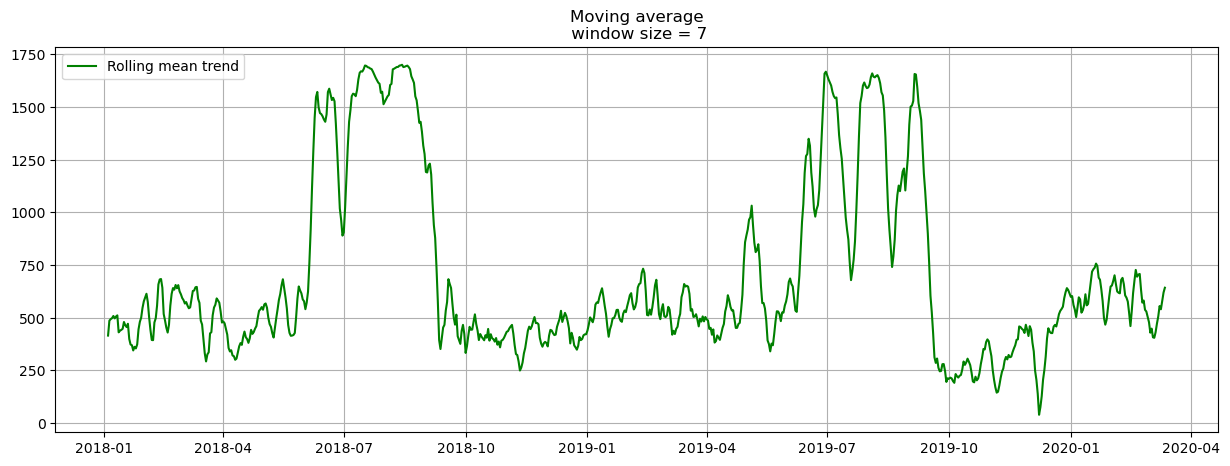

In [50]:
plotMovingAverage(daily_df.ActivePower,7)

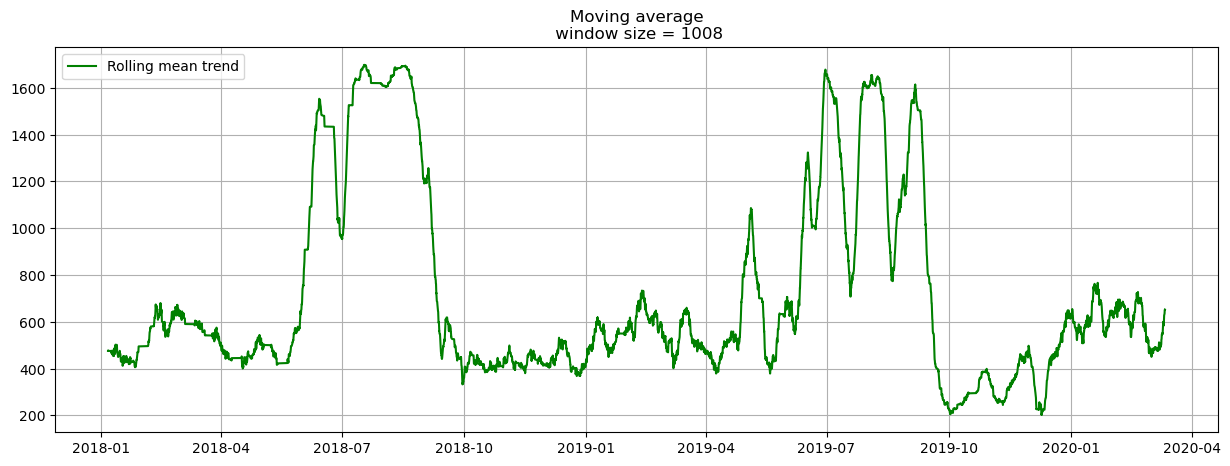

In [51]:
plotMovingAverage(df.ActivePower,1008)

In [52]:
def adf_test(timeseries):
    #Perform Augmented Dickey-Fuller test:
    print ('Results of Augmented Dickey-Fuller Test:')
    
    dftest = adfuller(timeseries, autolag='AIC')
    
    
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [12]:
adf_test(df.ActivePower)

Results of Augmented Dickey-Fuller Test:
Test Statistic                -1.522004e+01
p-value                        5.501421e-28
#Lags Used                     6.400000e+01
Number of Observations Used    7.713700e+04
Critical Value (1%)           -3.430435e+00
Critical Value (5%)           -2.861577e+00
Critical Value (10%)          -2.566790e+00
dtype: float64


Visually it just looks like strong seasonal patterns, but no real visible trend. The peaks and averages at lower points are similar across years.

### 1. ARIMA Approach:

In [53]:
history = daily_df[:-15]
test = daily_df[-15:]

In [54]:
def sarima_cv(dataset, p_values, d_values, q_values, P_values, D_values, Q_values, m):
    K = 5
    result = []
    best_rmse, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            trend_order = (p, d, q)
                            seasonal_order = (P, D, Q, m)
                            cfg = [(p, d, q), (P, D, Q, m)]
                            validation_size = 15
                            train_size = len(dataset) - validation_size * K
                            rmse = 0
                            for k in range(K):
                                train, test = dataset[0:train_size + k * validation_size], dataset[train_size + k * validation_size:train_size + (k + 1) * validation_size]
                                model = ARIMA(train['ActivePower'], order=trend_order, seasonal_order=seasonal_order)
                                model_fit = model.fit()
                                predictions = model_fit.forecast(validation_size)
                                rmse += np.sqrt(skmetrics.mean_squared_error(test['ActivePower'], predictions))

                            rmse_avg = rmse / K
                            result.append((cfg, rmse_avg))

                            if rmse_avg < best_rmse:
                                best_rmse, best_cfg = rmse_avg, cfg
                                print('SARIMA%s RMSE=%.3f' % (cfg, rmse_avg))
    print('Best SARIMA%s RMSE=%.3f' % (best_cfg, best_rmse))

In [55]:
p_values = range(0,1)
d_values = [0]
q_values = range(0,1,2)
P_values=[1,2]
D_values = [1]
Q_values =[2,3,5]
m = 7

sarima_cv(history, p_values, d_values, q_values, P_values, D_values, Q_values, m)

SARIMA[(0, 0, 0), (1, 1, 2, 7)] RMSE=245.287
SARIMA[(0, 0, 0), (1, 1, 5, 7)] RMSE=220.871
Best SARIMA[(0, 0, 0), (1, 1, 5, 7)] RMSE=220.871


In [71]:
sarima_model = ARIMA(history['ActivePower'], order=(0,0,0), seasonal_order=(1,1,5,7)).fit()
sarima_pred = sarima_model.forecast(15)
sarima_pred = pd.DataFrame(sarima_pred)
sarima_pred.set_index(test.index, inplace=True)

In [73]:
np.sqrt(skmetrics.mean_squared_error(sarima_pred, test.ActivePower))

177.10536896537394

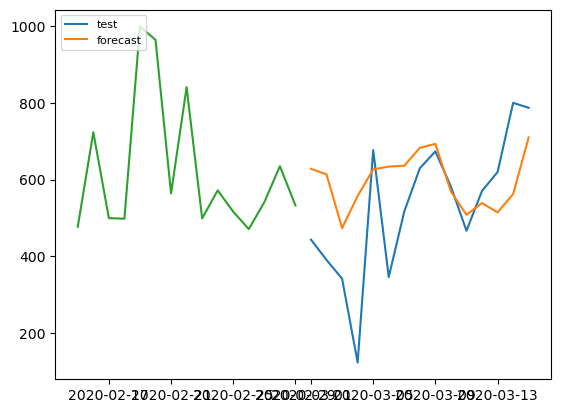

In [74]:
plt.figure 
plt.plot(test.index,test.ActivePower, label='test')
plt.plot(sarima_pred.index, sarima_pred, label='forecast')
plt.plot(history.ActivePower[-15:])
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [75]:
sarima_model = ARIMA(daily_df['ActivePower'], order=(0,0,1), seasonal_order=(1,1,2,7)).fit()
sarima_forecast = sarima_model.forecast(15)
sarima_forecast = pd.DataFrame(sarima_forecast)
idx = pd.date_range(daily_df.index[-1] + timedelta(days=1), periods=15, freq='D')
sarima_forecast.set_index(idx, inplace=True)
sarima_forecast

,predicted_mean
2020-03-16 00:00:00+00:00,676.754998
2020-03-17 00:00:00+00:00,516.021574
2020-03-18 00:00:00+00:00,432.314064
2020-03-19 00:00:00+00:00,619.839860
2020-03-20 00:00:00+00:00,543.127100
2020-03-21 00:00:00+00:00,680.841290
2020-03-22 00:00:00+00:00,686.860879
2020-03-23 00:00:00+00:00,626.846138
2020-03-24 00:00:00+00:00,522.780087
2020-03-25 00:00:00+00:00,420.332478


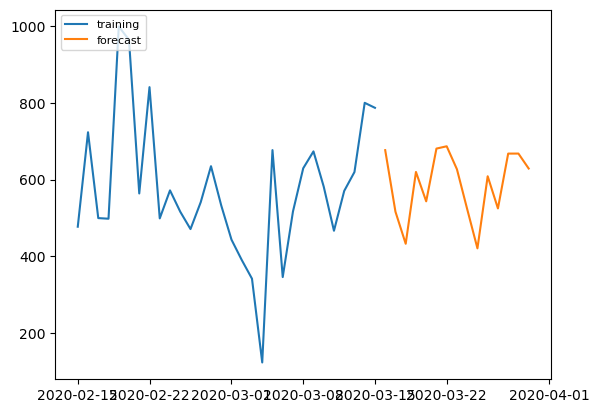

In [76]:
plt.figure 
plt.plot(daily_df.index[-30:],daily_df.ActivePower[-30:], label='training')
plt.plot(sarima_forecast.index, sarima_forecast, label='forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### 2. Prophet Approach:

In [77]:
prophet_df = daily_df.reset_index()
prophet_df.drop('WindSpeed', axis=1, inplace=True)
prophet_df['Datetime'] = prophet_df['Datetime'].dt.tz_localize(None)
prophet_df.rename(columns={'Datetime':'ds','ActivePower':'y'}, inplace=True)
prophet_df.head()

,ds,y
0,2018-01-01,366.223561
1,2018-01-02,462.550740
2,2018-01-03,454.417752
3,2018-01-04,369.952190
4,2018-01-05,319.446595


In [78]:
history = prophet_df[:-15]
test = prophet_df[-15:]

In [79]:
m1 = Prophet()
m1.fit(history)
future = m1.make_future_dataframe(periods=15)
forecast1 = m1.predict(future)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

21:15:06 - cmdstanpy - INFO - Chain [1] start processing
21:15:06 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
800,2020-03-11,531.792520,223.067650,853.732156
801,2020-03-12,554.791701,235.443628,891.136822
802,2020-03-13,504.651977,210.447996,825.840959
803,2020-03-14,508.492655,200.324825,811.712548
804,2020-03-15,501.545821,180.510943,812.461815


In [80]:
np.sqrt(skmetrics.mean_squared_error(forecast1.yhat[-15:], test.y))

183.2673333007844

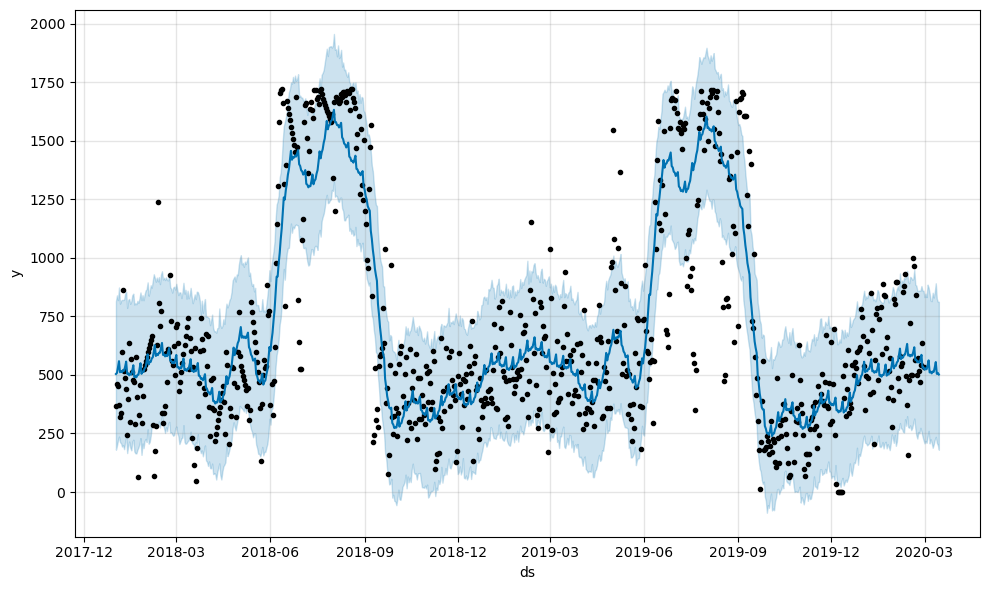

In [81]:
fig1 = m1.plot(forecast1)
# fig1_2 = m1.plot_components(forecast1)

In [82]:
m2 = Prophet()
m2.add_seasonality(name='quarterly', period=90, fourier_order=6)
forecast2 = m2.fit(history).predict(future)
# fig = m2.plot_components(forecast2)

21:15:08 - cmdstanpy - INFO - Chain [1] start processing
21:15:08 - cmdstanpy - INFO - Chain [1] done processing


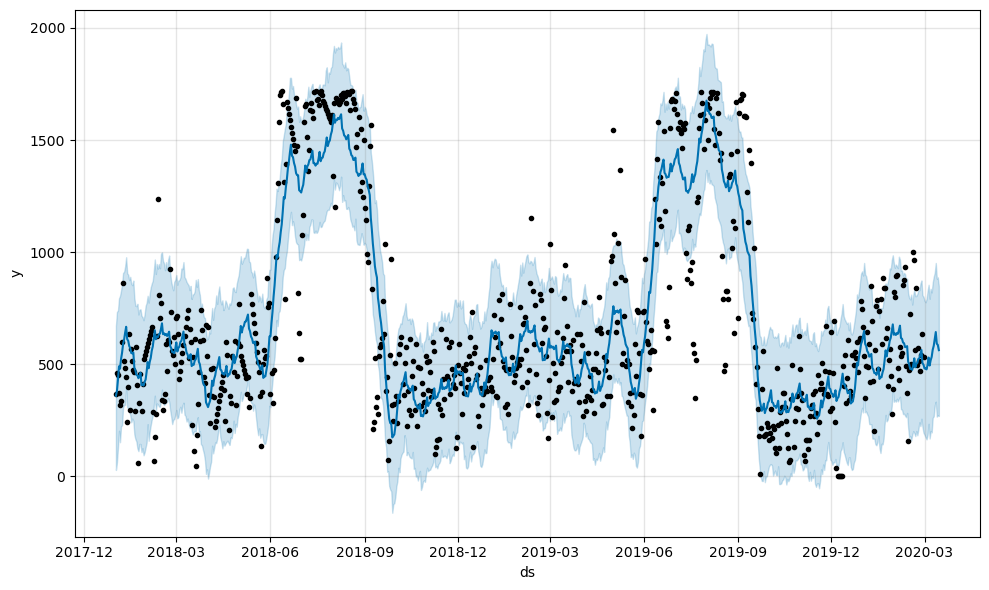

In [83]:
fig2 = m2.plot(forecast2)

In [84]:
np.sqrt(skmetrics.mean_squared_error(forecast2.yhat[-15:], test.y))

154.7651738123

In [85]:
m3 = Prophet(weekly_seasonality=False,daily_seasonality=False, changepoint_prior_scale=0.06)
m3.add_seasonality(name='yearly', period= 365, fourier_order=9)
m3.add_seasonality(name='quarterly', period= 91, fourier_order=6)
m3.add_seasonality(name='bimonthly', period= 15, fourier_order=2)
m3.add_seasonality(name='daily', period= 1, fourier_order=26)
m3.fit(history[59:])

future = m3.make_future_dataframe(periods=15)
forecast3 = m3.predict(future)
np.sqrt(skmetrics.mean_squared_error(forecast3.yhat[-15:], test.y))
# fig3 = m3.plot_components(forecast3)

21:15:10 - cmdstanpy - INFO - Chain [1] start processing
21:15:10 - cmdstanpy - INFO - Chain [1] done processing


136.57422631831275

In [86]:
m = Prophet(weekly_seasonality=False, changepoint_prior_scale=0.06)
m.add_seasonality(name='yearly', period= 365, fourier_order=9)
m.add_seasonality(name='quarterly', period=91, fourier_order=6)
m.add_seasonality(name='bimonthly', period= 15, fourier_order=2)
m.add_seasonality(name='daily', period= 1, fourier_order=26)

m.fit(prophet_df[59:])
future = m.make_future_dataframe(periods=15)
forecast = m.predict(future)


21:15:11 - cmdstanpy - INFO - Chain [1] start processing
21:15:11 - cmdstanpy - INFO - Chain [1] done processing


### Forecasting WindSpeed to add to model

In [87]:
prophet_df = daily_df.reset_index()
prophet_df['Datetime'] = prophet_df['Datetime'].dt.tz_localize(None)
prophet_df.rename(columns={'Datetime':'ds','WindSpeed':'y'}, inplace=True)
history = prophet_df[:-15]
test = prophet_df[-15:]
prophet_df.head()


,ds,ActivePower,y
0,2018-01-01,366.223561,5.263797
1,2018-01-02,462.550740,5.390719
2,2018-01-03,454.417752,5.295225
3,2018-01-04,369.952190,5.094994
4,2018-01-05,319.446595,4.915224


21:15:12 - cmdstanpy - INFO - Chain [1] start processing
21:15:12 - cmdstanpy - INFO - Chain [1] done processing


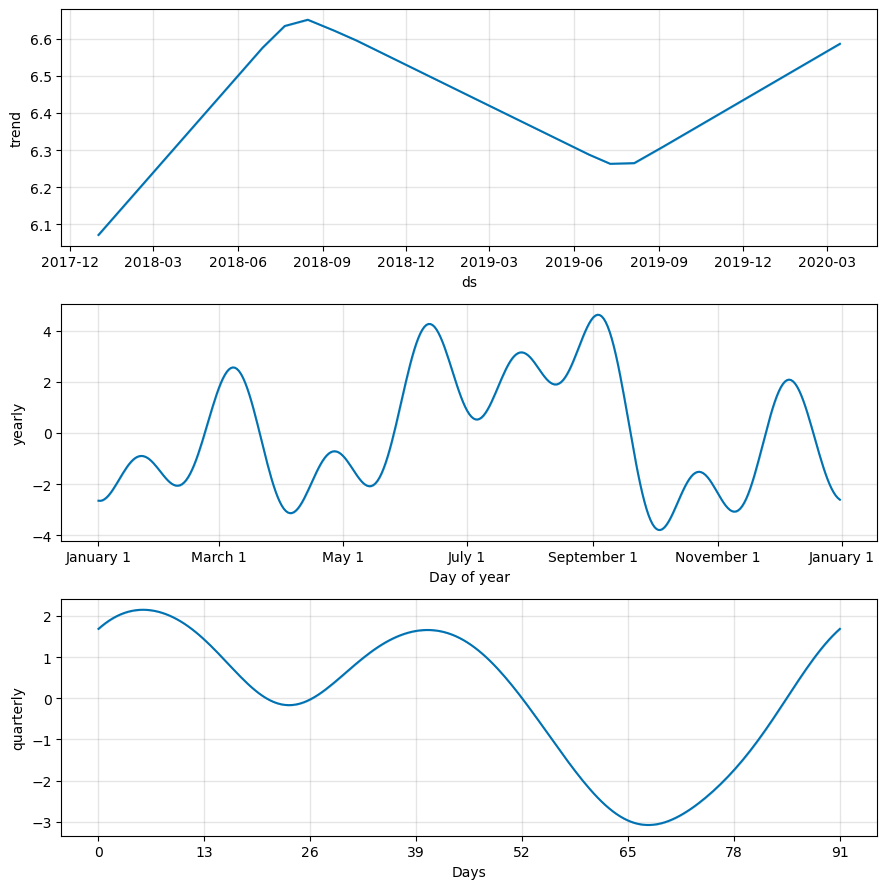

In [88]:
mws = Prophet(weekly_seasonality=False)
mws.add_seasonality(name='quarterly', period=91, fourier_order=6)
mws.fit(history)
future = mws.make_future_dataframe(periods=15)
forecastws = mws.predict(future)
fig3 = mws.plot_components(forecastws)

In [89]:
np.sqrt(skmetrics.mean_squared_error(forecastws.yhat[-15:], test.y))

0.7462180635314671

In [90]:
prophet_df = daily_df.reset_index()
prophet_df['Datetime'] = prophet_df['Datetime'].dt.tz_localize(None)
prophet_df.rename(columns={'Datetime':'ds','ActivePower':'y'}, inplace=True)
history = prophet_df[:-15]
test = prophet_df[-15:]
prophet_df.head()

,ds,y,WindSpeed
0,2018-01-01,366.223561,5.263797
1,2018-01-02,462.550740,5.390719
2,2018-01-03,454.417752,5.295225
3,2018-01-04,369.952190,5.094994
4,2018-01-05,319.446595,4.915224


21:15:14 - cmdstanpy - INFO - Chain [1] start processing
21:15:14 - cmdstanpy - INFO - Chain [1] done processing


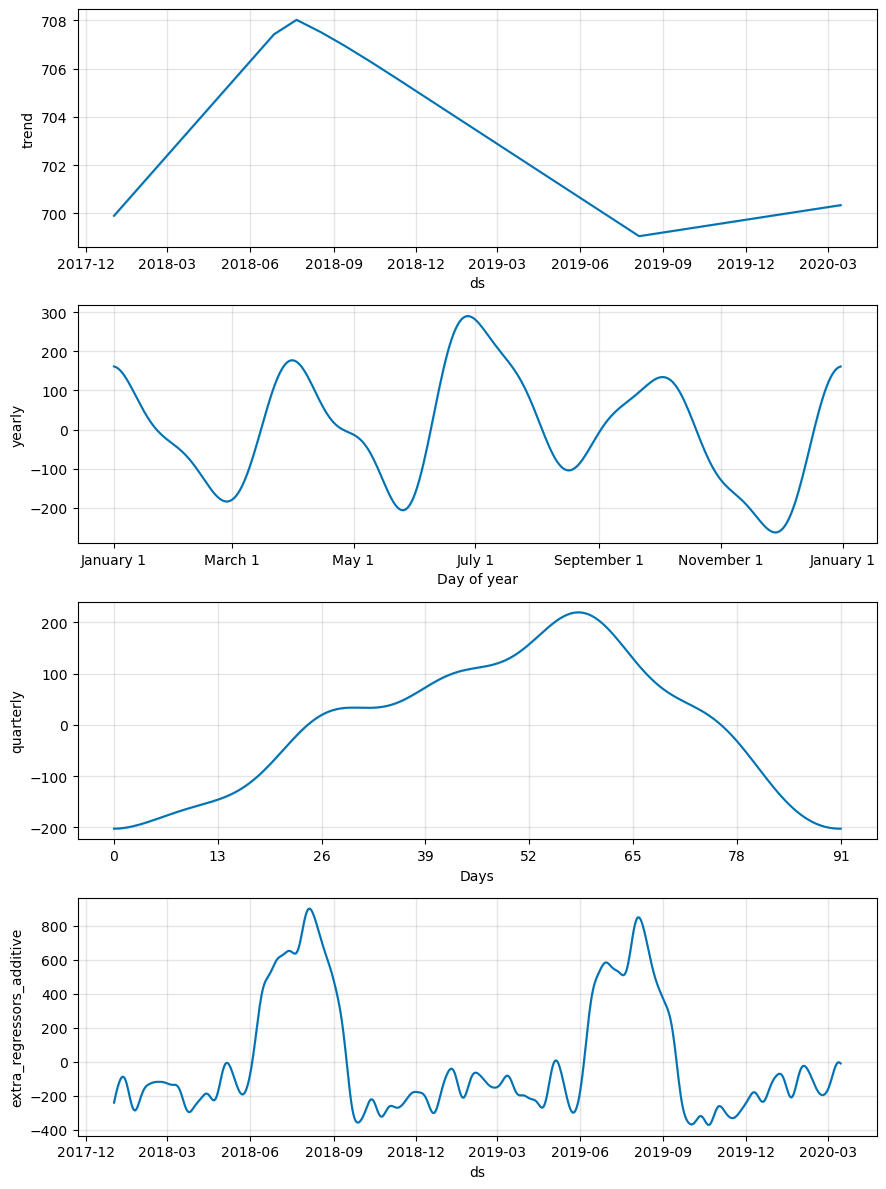

In [91]:
m4 = Prophet(weekly_seasonality=False)
m4.add_seasonality(name='quarterly', period=91, fourier_order=6)
m4.add_regressor('WindSpeed')
m4.fit(history)
future = m4.make_future_dataframe(periods=15)
future['WindSpeed'] = forecastws.yhat
forecast4 = m4.predict(future)
fig4 = m4.plot_components(forecast4)

In [92]:
np.sqrt(skmetrics.mean_squared_error(forecast4.yhat[-15:], test.y))

158.87013929213367

##### Prophet model 3 ended up returning the best test RMSE of 136.57.

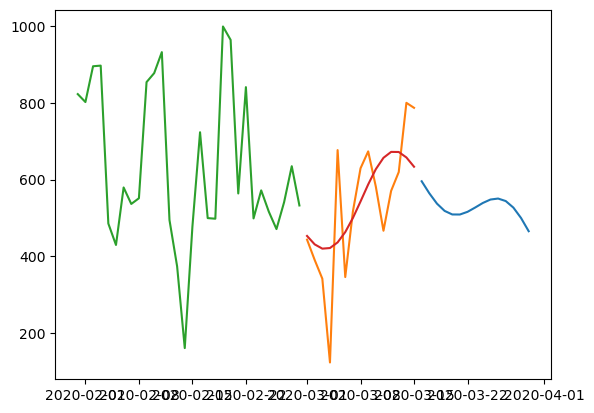

In [93]:
plt.plot(forecast.ds[-15:],forecast.yhat[-15:])
plt.plot(test.ds[-15:],test.y[-15:])
plt.plot(history.ds[-30:], history.y[-30:])
plt.plot(forecast3.ds[-15:],forecast3.yhat[-15:])

plt.show()

In [94]:
forecast = forecast[['ds','yhat']]
final_forecast = forecast[-15:]
final_forecast.rename(columns={'ds':'Date','yhat':'Forecasting'}, inplace=True)
final_forecast

,Date,Forecasting
746,2020-03-16,595.495992
747,2020-03-17,564.106182
748,2020-03-18,537.101380
749,2020-03-19,518.156068
750,2020-03-20,508.844643
751,2020-03-21,508.706445
752,2020-03-22,515.727663
753,2020-03-23,526.928050
754,2020-03-24,538.830496
755,2020-03-25,547.796958


In [95]:
final_forecast.to_csv('test_forecast.csv', index=False)